### 1. Import thư viện và đọc dữ liệu

In [71]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTENC
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score
)

In [72]:
DATA_PATH = "dataset/METABRIC_RNA_Mutation.csv"
RANDOM_STATE = 42
CV = 5
OUT_DIR = "model"

In [73]:
df=pd.read_csv(DATA_PATH)

C:\Users\DUC AN\AppData\Local\Temp\ipykernel_21724\2843030417.py:1: DtypeWarning: Columns (678,688,690,692) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv(DATA_PATH)


In [74]:
df

,patient_id,age_at_diagnosis,type_of_breast_surgery,cancer_type,cancer_type_detailed,cellularity,chemotherapy,pam50_+_claudin-low_subtype,cohort,er_status_measured_by_ihc,...,mtap_mut,ppp2cb_mut,smarcd1_mut,nras_mut,ndfip1_mut,hras_mut,prps2_mut,smarcb1_mut,stmn2_mut,siah1_mut
0,0,75.65,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,NaN,0,claudin-low,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
1,2,43.19,BREAST CONSERVING,Breast Cancer,Breast Invasive Ductal Carcinoma,High,0,LumA,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
2,5,48.87,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,High,1,LumB,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
3,6,47.68,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,Moderate,1,LumB,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
4,8,76.97,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,High,1,LumB,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1899,7295,43.10,BREAST CONSERVING,Breast Cancer,Breast Invasive Lobular Carcinoma,High,0,LumA,4.0,Positve,...,0,0,0,0,0,0,0,0,0,0
1900,7296,42.88,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,High,0,LumB,4.0,Positve,...,0,0,0,0,0,0,0,0,0,0
1901,7297,62.90,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,High,0,LumB,4.0,Positve,...,0,0,0,0,0,0,0,0,0,0
1902,7298,61.16,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,Moderate,0,LumB,4.0,Positve,...,0,0,0,0,0,0,0,0,0,0


### 2. Kiểm tra giá trị thiếu
##### - Mỗi cột trong bảng dữ liệu có thể có ô trống (missing value).
##### - Ví dụ: bảng thông tin bệnh nhân, có người chưa đo được HER2, ô đó để trống.
##### - df.isna().sum() đếm xem mỗi cột có bao nhiêu ô trống.
##### - Nếu nhiều ô trống, ta cần lấp đầy hoặc loại bỏ trước khi dùng cho machine learning.
##### -> Tóm tắt: kiểm tra xem cái danh sách bệnh nhân có chỗ nào thiếu thông tin không.


In [75]:
na_counts = df.isna().sum()
na_counts = na_counts[na_counts > 0]  

print(na_counts)

type_of_breast_surgery             22
cancer_type_detailed               15
cellularity                        54
er_status_measured_by_ihc          30
neoplasm_histologic_grade          72
tumor_other_histologic_subtype     15
primary_tumor_laterality          106
mutation_count                     45
oncotree_code                      15
3-gene_classifier_subtype         204
tumor_size                         20
tumor_stage                       501
death_from_cancer                   1
dtype: int64


### 3. Khám phá dữ liệu categorical (dạng chữ)

##### - Một số cột là dạng “category” (chữ, không phải số).
##### - Ví dụ her2_status có “Positive” hoặc “Negative”.
##### - .unique() cho biết trong cột này có bao nhiêu loại khác nhau.
##### - Giúp ta biết cách chuyển chữ thành số sau này (vì máy tính không hiểu chữ).

In [76]:
df["neoplasm_histologic_grade"].unique()

array([ 3.,  2.,  1., nan])

In [77]:
df["her2_status_measured_by_snp6"].unique()

array(['NEUTRAL', 'LOSS', 'GAIN', 'UNDEF'], dtype=object)

In [78]:
df["her2_status"].unique()

array(['Negative', 'Positive'], dtype=object)

### 4. Lựa chọn các feature quan trọng

##### - Trong bảng gốc có quá nhiều cột (cả gene expression + thông tin bệnh nhân).
##### - Chúng ta chỉ lấy những cột thật sự cần thiết để dự đoán.
##### - Giúp giảm phức tạp, dễ xử lý hơn

In [79]:
KEEP=["type_of_breast_surgery",
      "cancer_type",
      "cancer_type_detailed",
      "cellularity",
      "chemotherapy",
      "pam50_+_claudin-low_subtype",
      "neoplasm_histologic_grade",
      "her2_status",
      "hormone_therapy",
      'lymph_nodes_examined_positive',
      "nottingham_prognostic_index",
      "pr_status",
      "radio_therapy",
     ]


In [80]:

Categorical=["type_of_breast_surgery",
      "cancer_type",
      "cancer_type_detailed",
      "cellularity",
      "pam50_+_claudin-low_subtype",
      "her2_status",
      "pr_status"
     ]

In [81]:
df_features=df[KEEP]

In [82]:
# # Lấy 3 nhãn có số lượng mẫu lớn nhất
# top3_labels = df_features["cancer_type_detailed"].value_counts().nlargest(3).index

# # Ghi đè vào df_features (chỉ giữ lại 3 nhãn đó)
# df_features = df_features[df_features["cancer_type_detailed"].isin(top3_labels)]

# print("Shape sau khi lọc:", df_features.shape)
# print(df_features["cancer_type_detailed"].value_counts())


In [83]:
na_counts = df_features.isna().sum()
na_counts = na_counts[na_counts > 0]  

print(na_counts)

type_of_breast_surgery       22
cancer_type_detailed         15
cellularity                  54
neoplasm_histologic_grade    72
dtype: int64


### 5. Trực quan hóa phân phối các biến categorical

##### - Vẽ biểu đồ cột cho biết mỗi loại trong cột xuất hiện bao nhiêu lần.
##### - Ví dụ, có 50 bệnh nhân giai đoạn 1, 30 bệnh nhân giai đoạn 2.
##### - Giúp ta nhìn tổng quát dữ liệu và phát hiện nếu dữ liệu bị lệch.

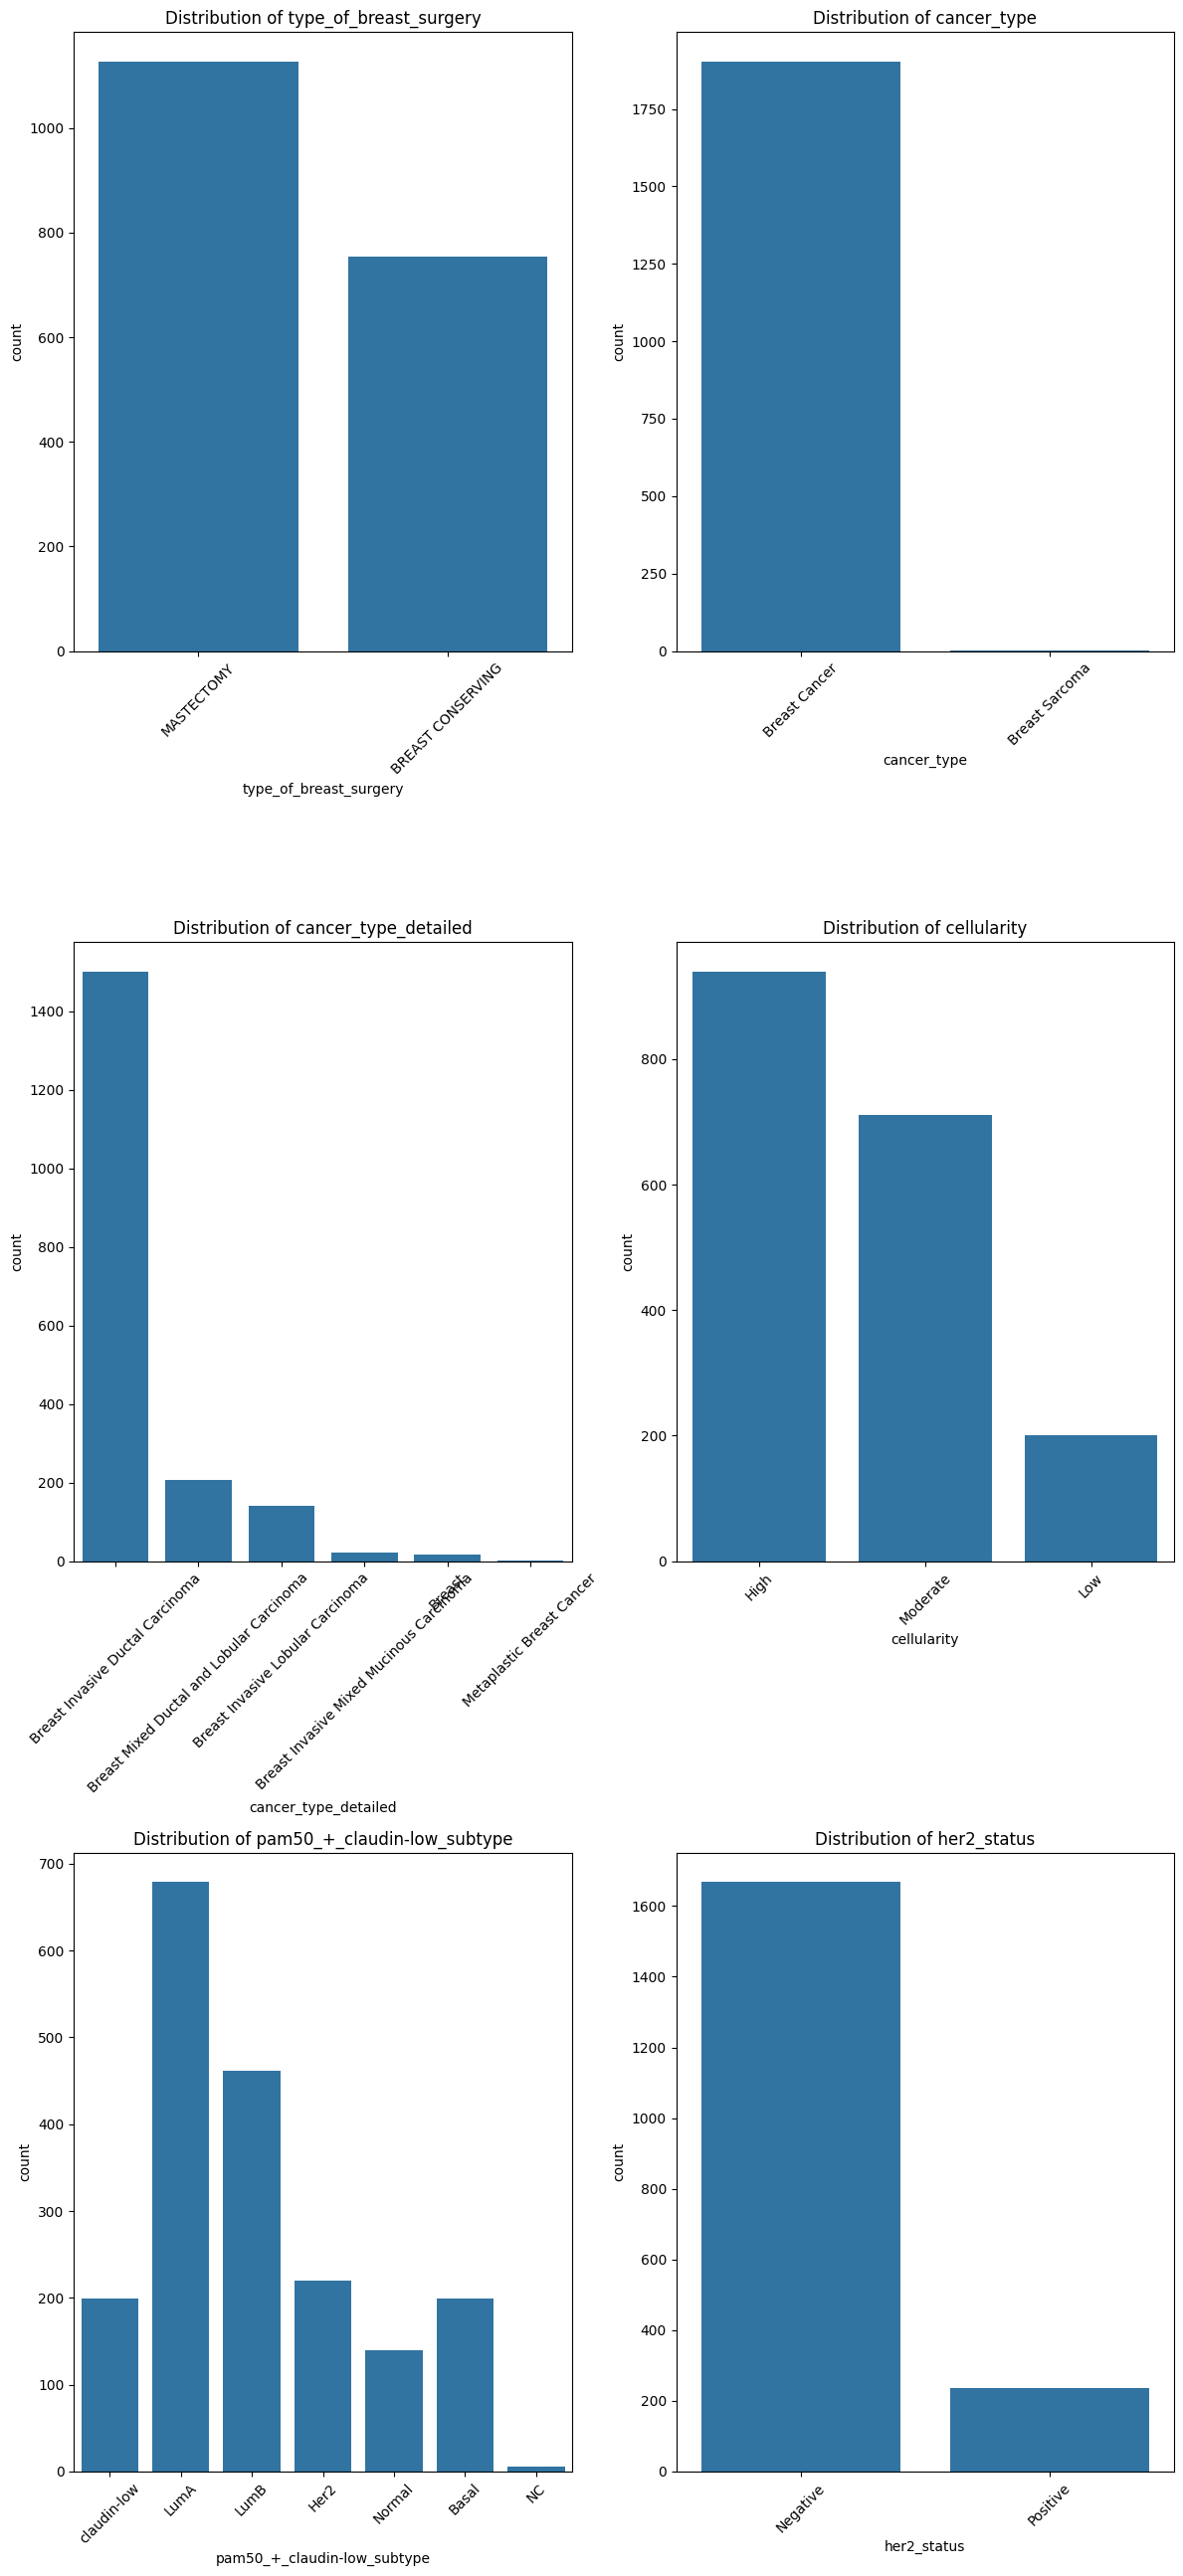

In [84]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=len(Categorical)//2, ncols=2, figsize=(12, 2*len(KEEP)))
axes=axes.flatten()
for col,ax in zip(Categorical,axes):
  
    sns.countplot(data=df, x=col,ax=ax)
    ax.set_title(f"Distribution of {col}")
    ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()
   

### 6. Xóa giá trị thiếu cho categorical (và toàn bộ dataset)

##### - Trong dữ liệu y khoa, việc điền ngẫu nhiên có thể tạo ra nhiễu.
##### - Do đó, thay vì điền, ta xóa luôn những hàng có dữ liệu thiếu.
##### - Như vậy, dataset chỉ giữ lại các bệnh nhân có thông tin đầy đủ.

In [85]:

df_features = df_features.dropna()

print("Shape sau khi drop missing:", df_features.shape)



Shape sau khi drop missing: (1749, 13)


In [86]:
df_features.isna().sum()

type_of_breast_surgery           0
cancer_type                      0
cancer_type_detailed             0
cellularity                      0
chemotherapy                     0
pam50_+_claudin-low_subtype      0
neoplasm_histologic_grade        0
her2_status                      0
hormone_therapy                  0
lymph_nodes_examined_positive    0
nottingham_prognostic_index      0
pr_status                        0
radio_therapy                    0
dtype: int64

In [87]:
df_features.head()

,type_of_breast_surgery,cancer_type,cancer_type_detailed,cellularity,chemotherapy,pam50_+_claudin-low_subtype,neoplasm_histologic_grade,her2_status,hormone_therapy,lymph_nodes_examined_positive,nottingham_prognostic_index,pr_status,radio_therapy
1,BREAST CONSERVING,Breast Cancer,Breast Invasive Ductal Carcinoma,High,0,LumA,3.0,Negative,1,0.0,4.020,Positive,1
2,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,High,1,LumB,2.0,Negative,1,1.0,4.030,Positive,0
3,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,Moderate,1,LumB,2.0,Negative,1,3.0,4.050,Positive,1
4,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,High,1,LumB,3.0,Negative,1,8.0,6.080,Positive,1
5,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,Moderate,0,LumB,3.0,Negative,1,0.0,4.062,Positive,1


### 7. Encode categorical thành số

##### - Máy học không hiểu chữ (“Positive”, “Negative”).
##### - Chúng ta chuyển chữ thành số:
##### “Negative” → 0
##### “Positive” → 1
##### - Tương tự với các cột khác.

In [88]:
from sklearn.preprocessing import LabelEncoder
import json

categorical_cols = df_features.select_dtypes(include=["object"]).columns
print("Các cột dạng object:", list(categorical_cols))

encoding_maps = {}

for col in categorical_cols:
    le = LabelEncoder()
    df_features[col] = le.fit_transform(df_features[col])
    # ép về int để JSON serializable
    encoding_maps[col] = {cls: int(code) for cls, code in zip(le.classes_, le.transform(le.classes_))}

# In ra rõ ràng
print("\n=== Encoding maps chi tiết ===")
for col, mapping in encoding_maps.items():
    print(f"\nCột: {col}")
    for original, encoded in mapping.items():
        print(f"   {original!r:25} -> {encoded}")

# Lưu JSON
with open("encoding_maps.json", "w", encoding="utf-8") as f:
    json.dump(encoding_maps, f, ensure_ascii=False, indent=4)



Các cột dạng object: ['type_of_breast_surgery', 'cancer_type', 'cancer_type_detailed', 'cellularity', 'pam50_+_claudin-low_subtype', 'her2_status', 'pr_status']

=== Encoding maps chi tiết ===

Cột: type_of_breast_surgery
   'BREAST CONSERVING'       -> 0
   'MASTECTOMY'              -> 1

Cột: cancer_type
   'Breast Cancer'           -> 0

Cột: cancer_type_detailed
   'Breast'                  -> 0
   'Breast Invasive Ductal Carcinoma' -> 1
   'Breast Invasive Lobular Carcinoma' -> 2
   'Breast Invasive Mixed Mucinous Carcinoma' -> 3
   'Breast Mixed Ductal and Lobular Carcinoma' -> 4

Cột: cellularity
   'High'                    -> 0
   'Low'                     -> 1
   'Moderate'                -> 2

Cột: pam50_+_claudin-low_subtype
   'Basal'                   -> 0
   'Her2'                    -> 1
   'LumA'                    -> 2
   'LumB'                    -> 3
   'NC'                      -> 4
   'Normal'                  -> 5
   'claudin-low'             -> 6

Cột: her2_stat

### Cân bằng dữ liệu

In [89]:
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTENC, SMOTE
import pandas as pd
import numpy as np

target_col = "cancer_type_detailed"

# --- 1. Xác định categorical columns hiện tại (trong X) ---
# Lưu ý: nếu bạn đã encode trước đó và tất cả đều numeric, danh sách này sẽ rỗng.
categorical_cols = df_features.drop(columns=[target_col]).select_dtypes(include=["object", "category"]).columns.tolist()
print("Detected categorical columns (object/category):", categorical_cols)


# --- 3. Nếu cần, encode các categorical columns (nếu chúng chưa được encode) ---
encoding_maps = {}
for col in categorical_cols:
    le = LabelEncoder()
    df_features[col] = df_features[col].astype(str)
    df_features[col] = le.fit_transform(df_features[col])
    encoding_maps[col] = dict(zip(le.classes_, le.transform(le.classes_)))

# --- 5. Chuẩn bị X, y và tìm index categorical cho SMOTENC ---
X = df_features.drop(columns=[target_col]).copy()
y = df_features[target_col].values

# If categorical_cols is empty, try to detect originally categorical columns by domain knowledge:
categorical_feature_indices = [X.columns.get_loc(c) for c in categorical_cols if c in X.columns]
print("Categorical feature indices for SMOTENC:", categorical_feature_indices)

# --- 6. Chọn SMOTENC nếu có categorical features, else dùng SMOTE ---
counts = Counter(y)
min_count = min(counts.values())
k_neighbors = min(5, max(1, min_count - 1))
print(f"class counts before sampling: {counts}, using k_neighbors={k_neighbors}")

if len(categorical_feature_indices) > 0:
    print("Using SMOTENC (has categorical features).")
    sampler = SMOTENC(categorical_features=categorical_feature_indices, k_neighbors=k_neighbors, random_state=RANDOM_STATE)
else:
    print("No categorical feature detected for SMOTENC -> using plain SMOTE.")
    sampler = SMOTE(k_neighbors=k_neighbors, random_state=RANDOM_STATE)

# --- 7. Áp dụng resampling ---
X_res, y_res = sampler.fit_resample(X.values, y)  # pass numpy arrays to be safe

# --- 8. Ghi lại vào df_features (ghi đè) ---
X_res_df = pd.DataFrame(X_res, columns=X.columns)
y_res_series = pd.Series(y_res, name=target_col)
df_features = pd.concat([X_res_df, y_res_series], axis=1)

# Shuffle để ngẫu nhiên và reset index
df_features = df_features.sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True)

print("After resampling, class distribution:")
print(df_features[target_col].value_counts())


Detected categorical columns (object/category): []
Categorical feature indices for SMOTENC: []
class counts before sampling: Counter({np.int64(1): 1399, np.int64(4): 191, np.int64(2): 127, np.int64(3): 20, np.int64(0): 12}), using k_neighbors=5
No categorical feature detected for SMOTENC -> using plain SMOTE.
After resampling, class distribution:
cancer_type_detailed
3    1399
2    1399
1    1399
4    1399
0    1399
Name: count, dtype: int64


### 8. Tách X và y
##### - X: tập đặc trưng (features)
##### - y: nhãn (label) cần dự đoán, ở đây là overall_survival

In [90]:
X = df_features.drop("cancer_type_detailed", axis=1)
y = df_features["cancer_type_detailed"]

print("X shape:", X.shape)
print("y shape:", y.shape)
print("y unique values:", y.unique())

X shape: (6995, 12)
y shape: (6995,)
y unique values: [3 2 1 4 0]


### 9. Chia dữ liệu train/test

In [91]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=RANDOM_STATE, stratify=y
)

print("Train size:", X_train.shape[0], "Test size:", X_test.shape[0])

Train size: 4896 Test size: 2099


### 10. Huấn luyện SVM

In [92]:
categorical_feature_indices = [X.columns.get_loc(c) for c in categorical_cols if c in X.columns]

pipe = ImbPipeline([
    ("scaler", StandardScaler()),
    ("svc", SVC(class_weight="balanced", random_state=RANDOM_STATE))
])

param_grid = { "svc__C": [0.1, 1, 10], "svc__kernel": ["linear", "rbf"], "svc__gamma": ["scale", "auto"] }

grid = GridSearchCV(pipe, param_grid, cv=StratifiedKFold(n_splits=CV, shuffle=True, random_state=RANDOM_STATE),
                    scoring="f1_macro", n_jobs=-1, verbose=2)

grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)
best_pipe = grid.best_estimator_

# Evaluate on test set
y_pred = best_pipe.predict(X_test)
print("Test accuracy:", accuracy_score(y_test, y_pred))
print("Classification report:\n", classification_report(y_test, y_pred, digits=4))

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best params: {'svc__C': 10, 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}
Test accuracy: 0.8113387327298713
Classification report:
               precision    recall  f1-score   support

           0     0.9073    0.9786    0.9416       420
           1     0.7953    0.6492    0.7148       419
           2     0.7778    0.7500    0.7636       420
           3     0.7996    0.9786    0.8801       420
           4     0.7636    0.7000    0.7304       420

    accuracy                         0.8113      2099
   macro avg     0.8087    0.8113    0.8061      2099
weighted avg     0.8087    0.8113    0.8062      2099



### Vẽ biểu đồ kết quả

Saved: figures\precision_recall_f1_per_class.png


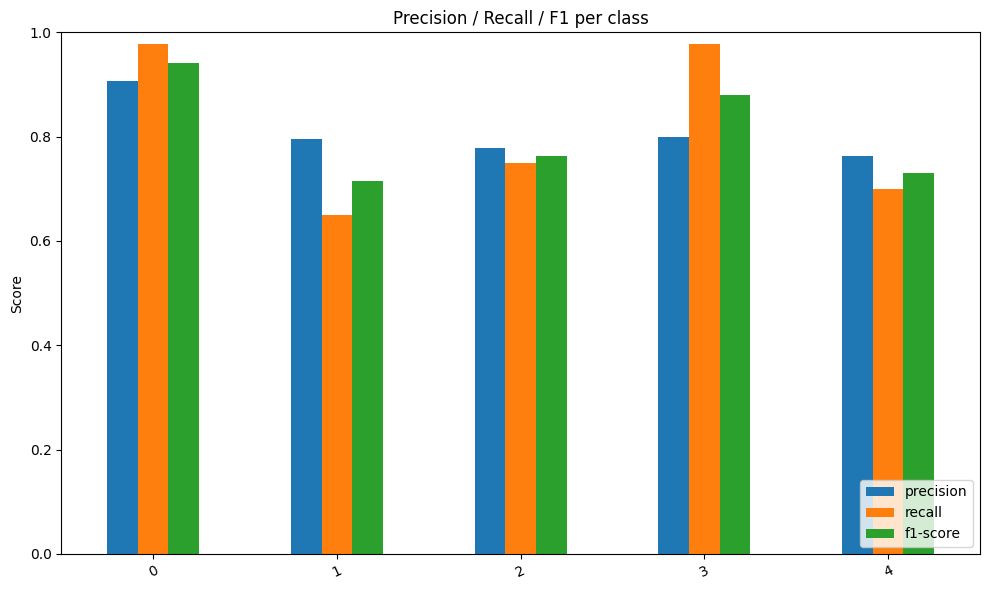

Saved: figures\summary_accuracy_macrof1.png


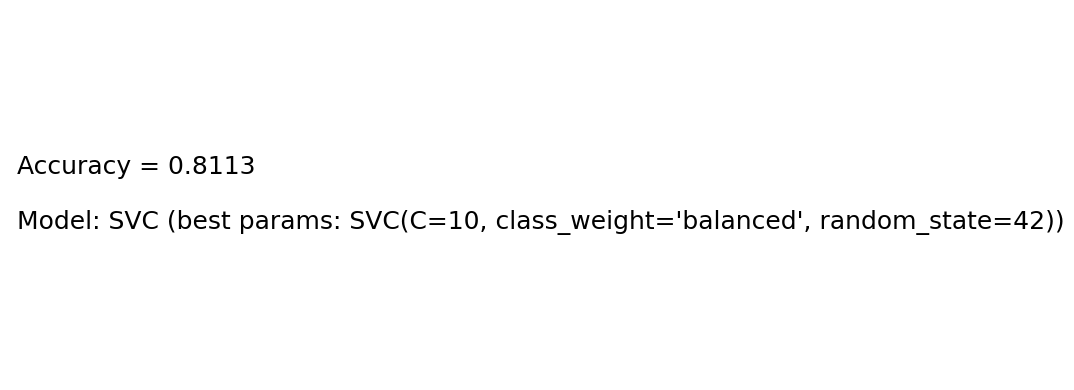

All figures saved to: figures


In [93]:
# --- Imports cần thiết ---
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    accuracy_score,
    f1_score
)

# --- Thông số lưu file (thích hợp cho slide) ---
OUT_DIR = "figures"
os.makedirs(OUT_DIR, exist_ok=True)
DPI = 200
SLIDE_FIGSIZE = (10, 6)   # kích thước tốt cho slide

# --- Giả sử bạn đã có y_test, y_pred, X_train, X_test, y_train ---
# Nếu chưa, thay bằng biến tương ứng của bạn.

labels = np.unique(np.concatenate([y_test, y_pred]))  # đảm bảo thứ tự nhãn
labels = list(labels)


# --- 2) Precision / Recall / F1 bar chart per class ---
report_dict = classification_report(y_test, y_pred, labels=labels, output_dict=True, zero_division=0)
# convert to DataFrame
rep_df = pd.DataFrame(report_dict).T
# keep only precision, recall, f1-score for class rows (filter out macro avg / accuracy rows)
metric_rows = [r for r in rep_df.index if r not in ("accuracy", "macro avg", "weighted avg")]
metrics_to_plot = rep_df.loc[metric_rows, ["precision", "recall", "f1-score"]]

fig, ax = plt.subplots(figsize=SLIDE_FIGSIZE)
metrics_to_plot.plot(kind="bar", ax=ax)
ax.set_ylabel("Score")
ax.set_ylim(0,1)
ax.set_title("Precision / Recall / F1 per class")
ax.legend(loc="lower right")
plt.xticks(rotation=25)
plt.tight_layout()
fn = os.path.join(OUT_DIR, "precision_recall_f1_per_class.png")
plt.savefig(fn, dpi=DPI)
print("Saved:", fn)
plt.show()


# --- 4) Summary figure: Accuracy + Macro F1 (dùng cho 1 slide tóm tắt) ---
acc = accuracy_score(y_test, y_pred)

fig, ax = plt.subplots(figsize=(10,4))
ax.axis("off")
text = f"Accuracy = {acc:.4f}\n\nModel: SVC (best params: {getattr(best_pipe, 'named_steps', {}).get('svc', '')})"
ax.text(0.01, 0.5, text, fontsize=18, va="center")
plt.tight_layout()
fn = os.path.join(OUT_DIR, "summary_accuracy_macrof1.png")
plt.savefig(fn, dpi=DPI)
print("Saved:", fn)
plt.show()


# --- Extra: nếu muốn, xuất classification_report dạng text file ---
with open(os.path.join(OUT_DIR, "classification_report.txt"), "w") as f:
    f.write(classification_report(y_test, y_pred, digits=4, zero_division=0))

print("All figures saved to:", OUT_DIR)


Saved: figures\roc_auc_curves.png


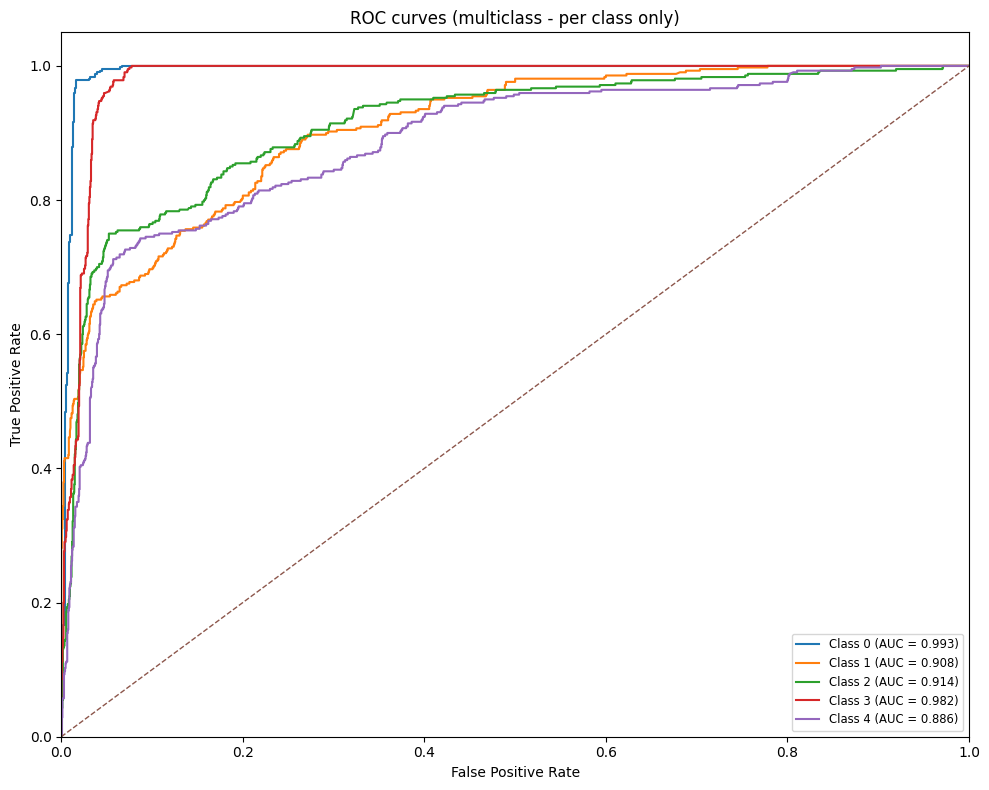

Per-class AUCs:
  0: 0.9929
  1: 0.9078
  2: 0.9136
  3: 0.9815
  4: 0.8864


In [94]:
# ROC / AUC plotting (binary or multiclass)
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, roc_auc_score

os.makedirs(OUT_DIR, exist_ok=True)
fn = os.path.join(OUT_DIR, "roc_auc_curves.png")

# Ensure labels is a list of all classes in the test (same as used before)
labels = list(np.unique(np.concatenate([y_test, y_pred])))

# --- 1) get score matrix (n_samples, n_classes) or (n_samples,) for binary ---
model = best_pipe
# try predict_proba first
y_score = None
try:
    # if pipeline, get estimator step output
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test)
    else:
        # try to find 'svc' step or last estimator
        last = None
        if hasattr(model, "named_steps"):
            # try last named step
            last = list(model.named_steps.values())[-1]
        elif hasattr(model, "steps"):
            last = list(model.steps)[-1]
        if last is not None and hasattr(last, "predict_proba"):
            y_score = last.predict_proba(X_test)
except Exception:
    y_score = None

# fallback to decision_function if predict_proba not available
if y_score is None:
    try:
        if hasattr(model, "decision_function"):
            df = model.decision_function(X_test)
        else:
            last = None
            if hasattr(model, "named_steps"):
                last = list(model.named_steps.values())[-1]
            if last is not None and hasattr(last, "decision_function"):
                df = last.decision_function(X_test)
            else:
                df = None
        y_score = df
    except Exception:
        y_score = None

if y_score is None:
    raise RuntimeError("Model does not support predict_proba or decision_function. "
                       "Retrain SVC with probability=True or use an estimator that provides scores.")

# --- 2) Prepare y_test binarized for multiclass ROC ---
y_test_array = np.array(y_test)
n_classes = len(labels)

# If binary and y_score is 1D or shape (n_samples, 1) -> handle separately
if n_classes == 2:
    # ensure y_score is shape (n_samples,)
    if y_score.ndim > 1 and y_score.shape[1] > 1:
        # take score for positive class (second column)
        score_pos = y_score[:, 1]
    else:
        score_pos = y_score.ravel()
    # binarize true labels to {0,1} (choose labels[1] as positive)
    y_test_bin = (y_test_array == labels[1]).astype(int)
    fpr, tpr, _ = roc_curve(y_test_bin, score_pos)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8,6))
    plt.plot(fpr, tpr, lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0,1], [0,1], linestyle='--', lw=1)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve (binary)')
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.savefig(fn, dpi=DPI)
    print("Saved:", fn)
    plt.show()

else:
    # multiclass: y_score should be shape (n_samples, n_classes)
    if y_score.ndim == 1:
        raise RuntimeError("Received 1D scores for multiclass. Need per-class scores (n_samples, n_classes).")

    # Binarize y_test
    y_test_bin = label_binarize(y_test_array, classes=labels)  # shape (n_samples, n_classes)

    # compute ROC for each class
    fpr = {}
    tpr = {}
    roc_auc = {}
    for i, cls in enumerate(labels):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot all per-class ROC curves
    plt.figure(figsize=(10, 8))
    for i, cls in enumerate(labels):
        plt.plot(fpr[i], tpr[i], lw=1.5, label=f'Class {cls} (AUC = {roc_auc[i]:.3f})')

    # đường chéo random
    plt.plot([0,1], [0,1], linestyle='--', lw=1)

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curves (multiclass - per class only)')
    plt.legend(loc="lower right", fontsize='small')
    plt.tight_layout()
    plt.savefig(fn, dpi=DPI)
    print("Saved:", fn)
    plt.show()

# Print summary AUCs
try:
    if n_classes == 2:
        print(f"Binary ROC AUC = {roc_auc:.4f}")
    else:
        print("Per-class AUCs:")
        for i, cls in enumerate(labels):
            print(f"  {cls}: {roc_auc[i]:.4f}")
except Exception:
    pass


### Xuất Model

In [95]:
import joblib

joblib.dump(best_pipe, "model_v2/best_model.pkl")
print("✅ success")

✅ success
